# Data Analysis of Auction model

**No average bid increases for sniper bidder**

Sniper bidders' internal valuations are updated by a scalar factor drawn from a unifrom distribution in the range [1.2, 2.0]

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Global variable (which was used in the batch runs)
AUCTION_LENGTH = 100

In [2]:
legacy_df = pd.read_csv("../data/results_legacy_no_bid_increase.csv", index_col=0)

## Getting final row of each epoch

I.e., winning bids of each epoch

In [3]:
splits = np.where(legacy_df["Highest Bid"] == 0)[0]
splits = np.delete(splits, 0)
splits = np.append(splits, len(legacy_df["Highest Bid"]-1))
final_rows = splits - 1
print(final_rows)

[    100     201     302 ... 1009797 1009898 1009999]


In [4]:
final_prices_df = legacy_df.iloc[final_rows]
# Removing any rows which contain 0 or None
# These are edge cases where the model does not receive any bids in the first few timesteps
final_prices_df.drop(final_prices_df.index[np.where(final_prices_df["Highest Bid"] == 0)[0]], axis=0, inplace=True)

C:\Users\Will\AppData\Local\Temp\ipykernel_22056\1367672686.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_prices_df.drop(final_prices_df.index[np.where(final_prices_df["Highest Bid"] == 0)[0]], axis=0, inplace=True)


### Plotting histograms of winning bids

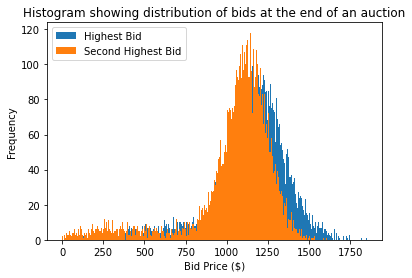

In [5]:
final_prices_df.plot.hist(bins=500)
plt.title("Histogram showing distribution of bids at the end of an auction")
plt.xlabel("Bid Price ($)")
plt.show()

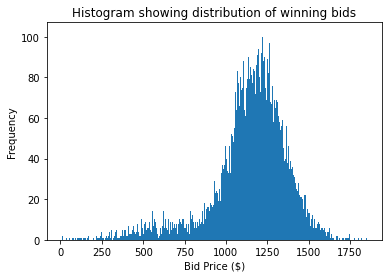

In [6]:
final_prices_df["Highest Bid"].plot.hist(bins=500)
plt.title("Histogram showing distribution of winning bids")
plt.xlabel("Bid Price ($)")
plt.show()

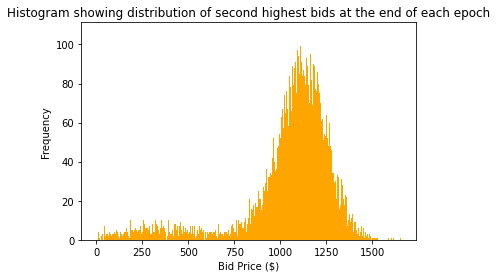

In [7]:
final_prices_df["Second Highest Bid"].plot.hist(bins=500, color="orange")
plt.title("Histogram showing distribution of second highest bids at the end of each epoch")
plt.xlabel("Bid Price ($)")
plt.show()

## Calculating win ratio of EarlyBidder : SniperBidder

In [8]:
earlyBidderWinPercent = 100 * (len(np.where(final_prices_df["Highest Bidder"] == "EarlyBidder")[0]) / len(final_prices_df["Highest Bidder"]))
sniperBidderWinPercent = 100 - earlyBidderWinPercent

In [13]:
print(f'EarlyBidder win percentage: {earlyBidderWinPercent:.2f}%')
print(f'SniperBidder win percentage: {sniperBidderWinPercent:.2f}%')

EarlyBidder win percentage: 59.92%
SniperBidder win percentage: 40.08%


## Finding sniper bidder wins

Plus calculating the percentage difference between the 1st and 2nd highest bids

In [14]:
sniper_bidder_wins = final_prices_df.iloc[np.where(final_prices_df["Highest Bidder"] == "SniperBidder")[0]]

In [15]:
sniper_bidder_premiums = (sniper_bidder_wins["Highest Bid"] - sniper_bidder_wins["Second Highest Bid"]) / sniper_bidder_wins["Second Highest Bid"]
print(sniper_bidder_premiums)

403        0.334802
504        0.056783
1009       0.311198
1110       0.109005
1211       0.043501
             ...   
1008484    0.303850
1009090    0.028307
1009494    0.058159
1009595    0.405628
1009898    0.220782
Length: 4008, dtype: float64


In [16]:
mean_sniper_premium = np.mean(sniper_bidder_premiums)
print(f'Mean sniper bidder premium: {mean_sniper_premium}')
median_sniper_premium = np.median(sniper_bidder_premiums)
print(f'Median sniper bidder premium: {median_sniper_premium}')

Mean sniper bidder premium: 0.12860863937896475
Median sniper bidder premium: 0.09258430914665142


## Finding early bidder wins

Plus calculating the percentage difference between the 1st and 2nd highest bids

In [17]:
early_bidder_wins = final_prices_df.iloc[np.where(final_prices_df["Highest Bidder"] == "EarlyBidder")[0]]

In [18]:
early_bidder_premiums = (early_bidder_wins["Highest Bid"] - early_bidder_wins["Second Highest Bid"]) / early_bidder_wins["Second Highest Bid"]
print(early_bidder_premiums)

100         0.031866
201         0.016441
302         0.092397
605        16.538450
706         0.481236
             ...    
1009292     0.049776
1009393     0.080999
1009696     0.017933
1009797    30.603023
1009999     0.019379
Length: 5992, dtype: float64


In [19]:
mean_early_bidder_premium = np.mean(early_bidder_premiums)
print(f'Mean early bidder premium: {mean_early_bidder_premium}')
median_early_bidder_premium = np.median(early_bidder_premiums)
print(f'Median early bidder premium: {median_early_bidder_premium}')

Mean early bidder premium: 0.3366227569096493
Median early bidder premium: 0.03953047072362227


## Finding mean auction bid (highest and second highest) at each timestep

In [26]:
mean_bids = legacy_df.groupby(np.arange(len(legacy_df))%(AUCTION_LENGTH+1)).mean()
print(f'Mean winning bid: {mean_bids["Highest Bid"][len(mean_bids)-1]}')

Mean winning bid: 1143.0002624842798


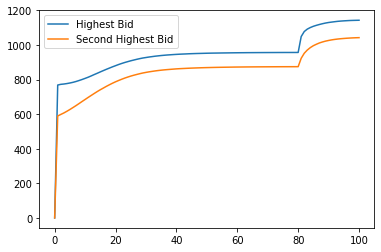

In [21]:
mean_bids.plot()
plt.show()

The noticeable jump from timestep 80 onwards characterises the SniperBidders being activated (for this dataset, bidTimeframe was set to 20). 

Notice how this strategy (i.e., not using average bid increase) results in bidders paying a high premium ($1143 on average vs $1055 for the bid-increase strategy).
- However, SniperBidders win much more frequently using the no bid increase strategy compared to those who use it (40.08% vs 13.18%)